## Code


##Spark Setup


In [0]:
# ==========================
# Step 1: Spark Setup in Databricks
# ==========================

# Check Spark Version
print("Spark Version:", spark.version)

# Check Environment and Cluster Information
print("Cluster Information:")
sc = spark.sparkContext
print(f"Spark Master: {sc.master}")
print(f"Spark App Name: {sc.appName}")


Spark Version: 3.5.0
Cluster Information:
Spark Master: local[8]
Spark App Name: Databricks Shell


##Load and Explore the Dataset


In [0]:
# ==========================
# Step 2: Load and Explore the Dataset
# ==========================

# Step 2.1: Define the correct path to the dataset
# Note: Use "/FileStore/tables/" directly, without "dbfs:/"
data_path = "/FileStore/tables/Sentiment140_CSV.csv"
columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Step 2.2: Load the dataset into a Spark DataFrame
df = spark.read.csv(data_path, header=False, inferSchema=True).toDF(*columns)

# Step 2.3: Display the schema of the dataset
print("Schema of the dataset:")
df.printSchema()

# Step 2.4: Show sample records
print("Sample records from the dataset:")
df.show(5, truncate=False)

# Step 2.5: Count total records in the dataset
total_records = df.count()
print(f"Total number of records: {total_records}")

# Step 2.6: Distribution of target labels (sentiment)
print("Target column distribution:")
df.groupBy('target').count().show()


Schema of the dataset:
root
 |-- target: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

Sample records from the dataset:
+------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|target|id        |date                        |flag    |user           |text                                                                                                               |
+------+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0     |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got D

##Data Cleaning and Prerocessing

Cleaned and tokenized data:
+---------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+
|text                                                                                                     |filtered_words                                                                                    |
+---------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------+
|switchfoot httptwitpiccomyzl  awww thats a bummer  you shoulda got david carr of third day to do it d    |[switchfoot, httptwitpiccomyzl, , awww, thats, bummer, , shoulda, got, david, carr, third, day, d]|
|is upset that he cant update his facebook by texting it and might cry as a result  school today also blah|[upset, cant, update, facebook, texti

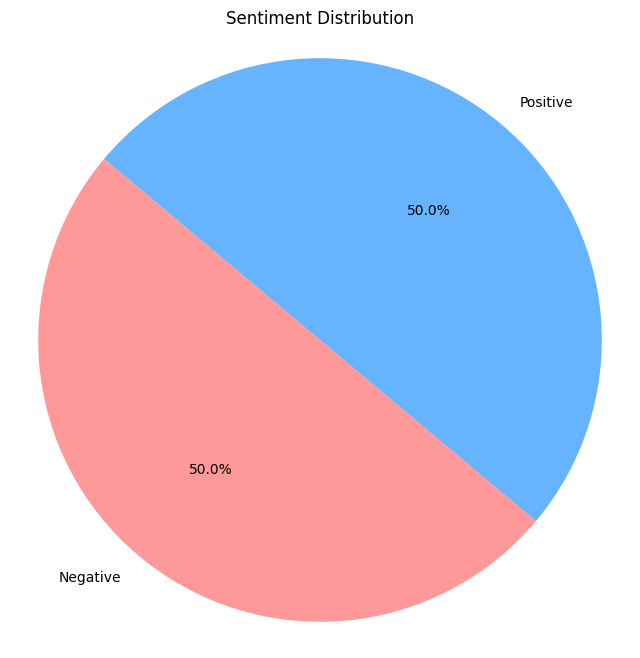

In [0]:
# ==========================
# Step 3: Data Cleaning, Preprocessing, and Sentiment Distribution
# ==========================
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import matplotlib.pyplot as plt

# Step 3.1: Clean the text column
# - Convert text to lowercase
# - Remove special characters and numbers
df_cleaned = df.withColumn('text', lower(col('text')))
df_cleaned = df_cleaned.withColumn('text', regexp_replace(col('text'), r'[^a-zA-Z\s]', ''))

# Step 3.2: Tokenize the text
# - Split the cleaned text into individual words
tokenizer = Tokenizer(inputCol='text', outputCol='words')
df_tokenized = tokenizer.transform(df_cleaned)

# Step 3.3: Remove stop words
# - Use Spark's built-in list of stop words
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
df_filtered = remover.transform(df_tokenized)

# Display the cleaned and tokenized data
print("Cleaned and tokenized data:")
df_filtered.select('text', 'filtered_words').show(5, truncate=False)

# Step 3.4: Generate a Pie Chart for Sentiment Distribution
# - Count the number of positive (4) and negative (0) labels
sentiment_counts = df_filtered.groupBy('target').count().toPandas()

# Prepare data for the pie chart
labels = ['Negative', 'Positive']
sizes = sentiment_counts['count']
colors = ['#ff9999', '#66b3ff']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()


##Feature Extraction

Vocabulary Size: 5000
Sample features:
+--------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|filtered_words                                                                                    |features                                                                                                       |
+--------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|[switchfoot, httptwitpiccomyzl, , awww, thats, bummer, , shoulda, got, david, carr, third, day, d]|(5000,[0,3,13,42,282,355,752,1101,1742,3358],[2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                        |
|[upset, cant, update, facebook, texting, might, cry, result, , school, today, also, blah]         |(5000,[0,

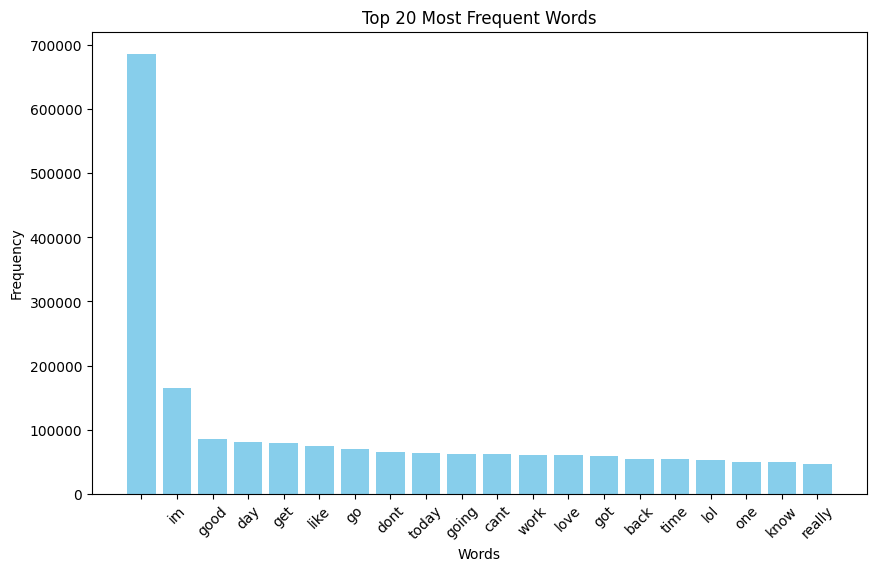

In [0]:
# ==========================
# Step 4: Feature Extraction and Visualization
# ==========================
from pyspark.ml.feature import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Step 4.1: Apply CountVectorizer
# - Convert tokenized words into numerical feature vectors
vectorizer = CountVectorizer(inputCol='filtered_words', outputCol='features', vocabSize=5000)
vectorizer_model = vectorizer.fit(df_filtered)
df_features = vectorizer_model.transform(df_filtered)

# Display the vocabulary size and sample features
vocab_size = len(vectorizer_model.vocabulary)
print(f"Vocabulary Size: {vocab_size}")
print("Sample features:")
df_features.select('filtered_words', 'features').show(5, truncate=False)

# Step 4.2: Inspect the Vocabulary and Top Words
# - Extract the top 20 words from the vocabulary
top_words = vectorizer_model.vocabulary[:20]

# Step 4.3: Calculate Word Frequencies
# - Collect the frequency of words for visualization
word_counts = df_features.select('features').rdd.flatMap(lambda row: row['features'].indices).countByValue()

# Convert word counts to a Pandas DataFrame for easy plotting
word_freq = pd.DataFrame({
    'word': [vectorizer_model.vocabulary[idx] for idx in word_counts.keys()],
    'count': word_counts.values()
}).sort_values(by='count', ascending=False).head(20)

# Step 4.4: Plot Bar Chart of Top Words
plt.figure(figsize=(10, 6))
plt.bar(word_freq['word'], word_freq['count'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()


##Target Label Preparation and Visualization

DataFrame with binary labels:
+------+-----+--------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|target|label|filtered_words                                                                                    |features                                                                                                       |
+------+-----+--------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|0     |0    |[switchfoot, httptwitpiccomyzl, , awww, thats, bummer, , shoulda, got, david, carr, third, day, d]|(5000,[0,3,13,42,282,355,752,1101,1742,3358],[2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])                        |
|0     |0    |[upset, cant, update, facebook, texting, might, cry,

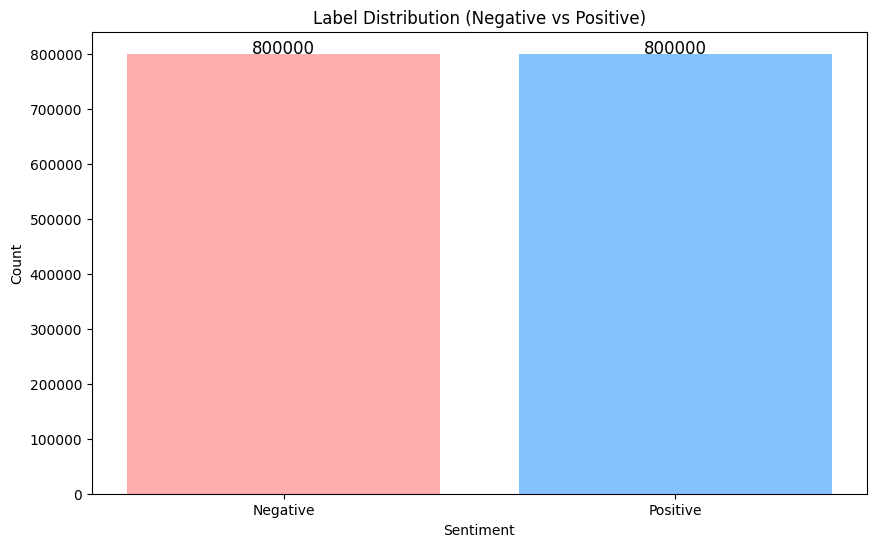

In [0]:
# ==========================
# Step 5: Target Label Preparation and Visualization
# ==========================
from pyspark.sql.functions import when
import pandas as pd
import matplotlib.pyplot as plt

# Step 5.1: Map the target values to binary labels
# - Map 0 (Negative) and 4 (Positive) to 0 and 1, respectively
df_labeled = df_features.withColumn('label', when(col('target') == 4, 1).otherwise(0))

# Step 5.2: Display the updated DataFrame
print("DataFrame with binary labels:")
df_labeled.select('target', 'label', 'filtered_words', 'features').show(5, truncate=False)

# Step 5.3: Verify label distribution
# - Count the number of positive and negative labels
label_distribution = df_labeled.groupBy('label').count().toPandas()
print("Label distribution:")
print(label_distribution)

# Step 5.4: Plot Bar Chart for Label Distribution
# Prepare data for visualization
labels = ['Negative', 'Positive']
counts = label_distribution['count']
colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=colors, alpha=0.8)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Label Distribution (Negative vs Positive)')

# Add data labels above the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1000, str(count), ha='center', fontsize=12)

plt.show()


## Train-Test Split

Training set size: 1280209
Test set size: 319791


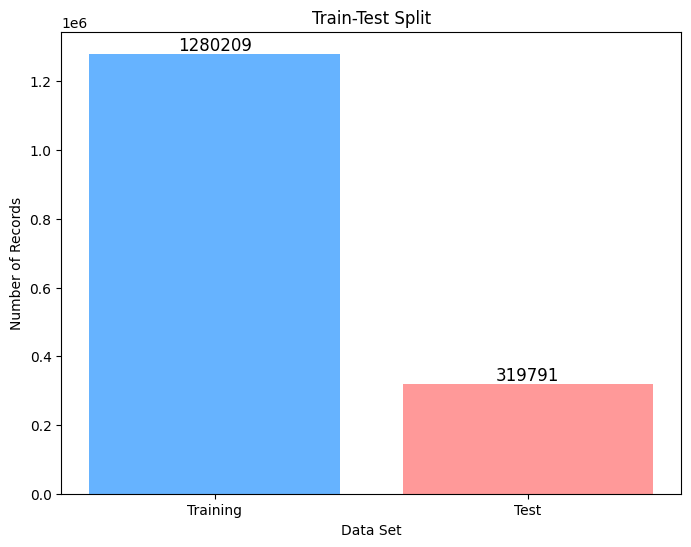

In [0]:
# ==========================
# Step 6: Train-Test Split
# ==========================
from pyspark.sql.functions import lit

# Step 6.1: Split the dataset into training and test sets
# - Use an 80-20 split for training and testing
train_df, test_df = df_labeled.randomSplit([0.8, 0.2], seed=42)

# Step 6.2: Display sizes of training and test sets
train_size = train_df.count()
test_size = test_df.count()
print(f"Training set size: {train_size}")
print(f"Test set size: {test_size}")

# Step 6.3: Visualize the split
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame for visualization
split_data = pd.DataFrame({
    'Set': ['Training', 'Test'],
    'Count': [train_size, test_size]
})

# Plot the split data
plt.figure(figsize=(8, 6))
bars = plt.bar(split_data['Set'], split_data['Count'], color=['#66b3ff', '#ff9999'])
plt.xlabel('Data Set')
plt.ylabel('Number of Records')
plt.title('Train-Test Split')

# Add data labels
for bar, count in zip(bars, split_data['Count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10000, str(count), ha='center', fontsize=12)

plt.show()


##Model Training

In [0]:
# ==========================
# Step 7: Model Training
# ==========================
from pyspark.ml.classification import LogisticRegression

# Step 7.1: Initialize the Logistic Regression model
# - Features: 'features'
# - Label: 'label'
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# Step 7.2: Train the Logistic Regression model
lr_model = lr.fit(train_df)

# Step 7.3: Display model coefficients and intercept
print("Logistic Regression Model Coefficients:")
print(lr_model.coefficients.toArray())  # Convert to an array for readability
print(f"Model Intercept: {lr_model.intercept}")

# Step 7.4: Display training summary metrics
training_summary = lr_model.summary

# Extracting accuracy
accuracy = training_summary.accuracy
print(f"Accuracy: {accuracy}")

# Extracting precision, recall, and F1 scores
precision = training_summary.precisionByLabel
recall = training_summary.recallByLabel
f1_scores = training_summary.fMeasureByLabel()

print(f"Precision (Negative Class): {precision[0]}")
print(f"Precision (Positive Class): {precision[1]}")
print(f"Recall (Negative Class): {recall[0]}")
print(f"Recall (Positive Class): {recall[1]}")
print(f"F1 Score (Negative Class): {f1_scores[0]}")
print(f"F1 Score (Positive Class): {f1_scores[1]}")

# Optionally, compute the weighted average F1 Score
weighted_f1 = sum(f1_scores) / len(f1_scores)
print(f"Weighted F1 Score: {weighted_f1}")

# Displaying the objective history for model convergence
print("Objective History (Loss function values):")
print(training_summary.objectiveHistory)


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Logistic Regression Model Coefficients:
[-0.04801477 -0.12140723  0.73727415 ... -1.00215947 -0.25039149
  0.83247088]
Model Intercept: 0.323947946493847
Accuracy: 0.7761998236225491
Precision (Negative Class): 0.7955948950185261
Precision (Positive Class): 0.7592236422895229
Recall (Negative Class): 0.7430752133198493
Recall (Positive Class): 0.8092895219239213
F1 Score (Negative Class): 0.7684387226713629
F1 Score (Positive Class): 0.7834575475940525
Weighted F1 Score: 0.7759481351327078
Objective History (Loss function values):
[0.6931470415596932, 0.5113283013523812, 0.4920073156366558, 0.4851478759562037, 0.48431339966310993, 0.48392613885175995, 0.4838821653178893, 0.48384545910603505, 0.4838314832996367, 0.4838261568753661, 0.48382325494839873]


##Model Evaluation and Visualization


+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |1.0       |[0.4675443555563333,0.5324556444436668] |
|0    |0.0       |[0.6493066822400497,0.3506933177599503] |
|0    |0.0       |[0.7619331896249789,0.2380668103750211] |
|0    |0.0       |[0.8806004343503857,0.11939956564961429]|
|0    |0.0       |[0.519681428798075,0.480318571201925]   |
+-----+----------+----------------------------------------+
only showing top 5 rows

Accuracy: 0.7740430468649837
Precision: 0.7754051707966334
Recall: 0.7740430468649837
F1 Score: 0.7737866683587898


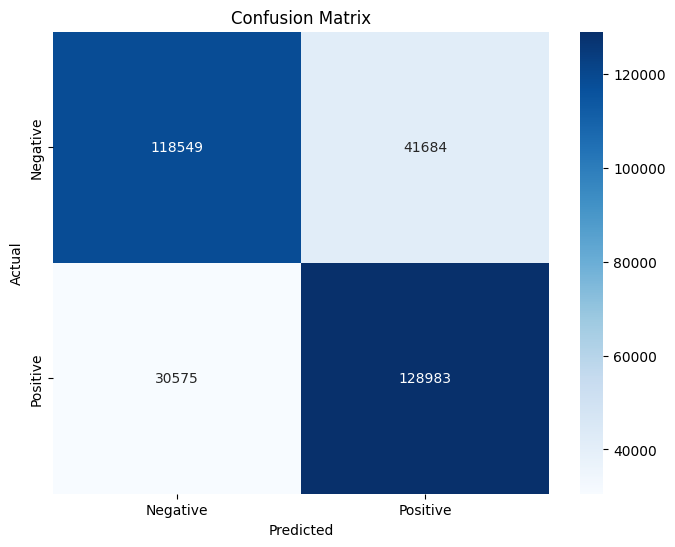

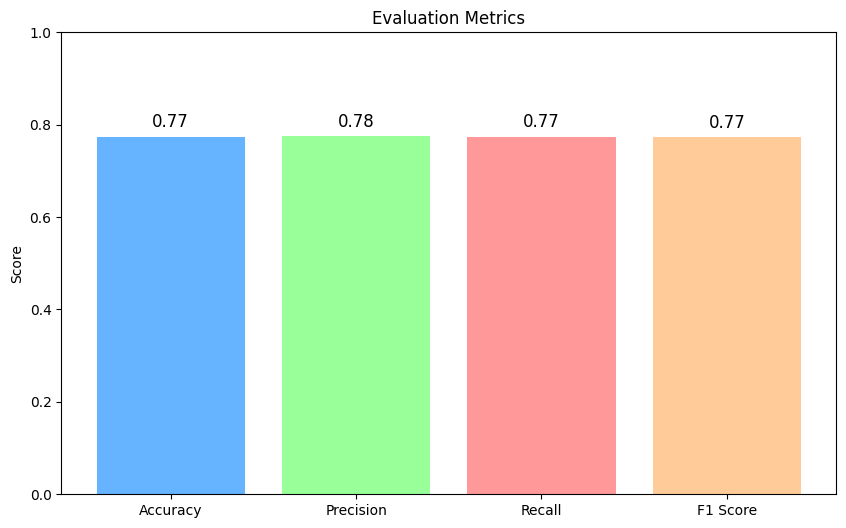

In [0]:
# ==========================
# Step 8: Model Evaluation and Visualization
# ==========================
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 8.1: Evaluate the model on the test set
# - Make predictions on the test set
predictions = lr_model.transform(test_df)
predictions.select('label', 'prediction', 'probability').show(5, truncate=False)

# Step 8.2: Compute evaluation metrics using Spark evaluator
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')
evaluator_f1 = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='f1')

accuracy = evaluator_accuracy.evaluate(predictions)
f1_score = evaluator_f1.evaluate(predictions)

# Step 8.3: Collect predictions and labels for additional metrics
y_true = [row['label'] for row in predictions.select('label').collect()]
y_pred = [row['prediction'] for row in predictions.select('prediction').collect()]

# Compute additional metrics using scikit-learn
report = classification_report(y_true, y_pred, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']

# Print evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

# Step 8.4: Compute and visualize confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 8.5: Visualize metrics
# - Bar Chart for Accuracy, Precision, Recall, and F1 Score
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=['#66b3ff', '#99ff99', '#ff9999', '#ffcc99'])
plt.ylim(0, 1)
plt.title('Evaluation Metrics')
plt.ylabel('Score')

# Annotate bars with metric values
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{score:.2f}', ha='center', fontsize=12)

plt.show()


##Feature Importance Analysis

Top 10 Positive Features:
                     Word  Importance
4335   wwwiamsoannoyedcom    5.378419
1717   wwwtweeteraddercom    2.701898
2053  wwwtweeterfollowcom    2.698139
1944              smiling    2.336460
2879          musicmonday    2.266904
1063      congratulations    2.208179
273               welcome    2.000372
4915                 hihi    1.946985
605                 smile    1.913424
3959                woooo    1.903969

Top 10 Negative Features:
               Word  Importance
4694      toothache   -2.762918
1137         gutted   -2.800625
4048         booooo   -2.809418
1259     depressing   -2.823646
2578  disappointing   -3.023298
4174        saddest   -3.123227
45              sad   -3.162315
4805      upsetting   -3.218228
4564    heartbroken   -3.435639
4957    condolences   -3.786872


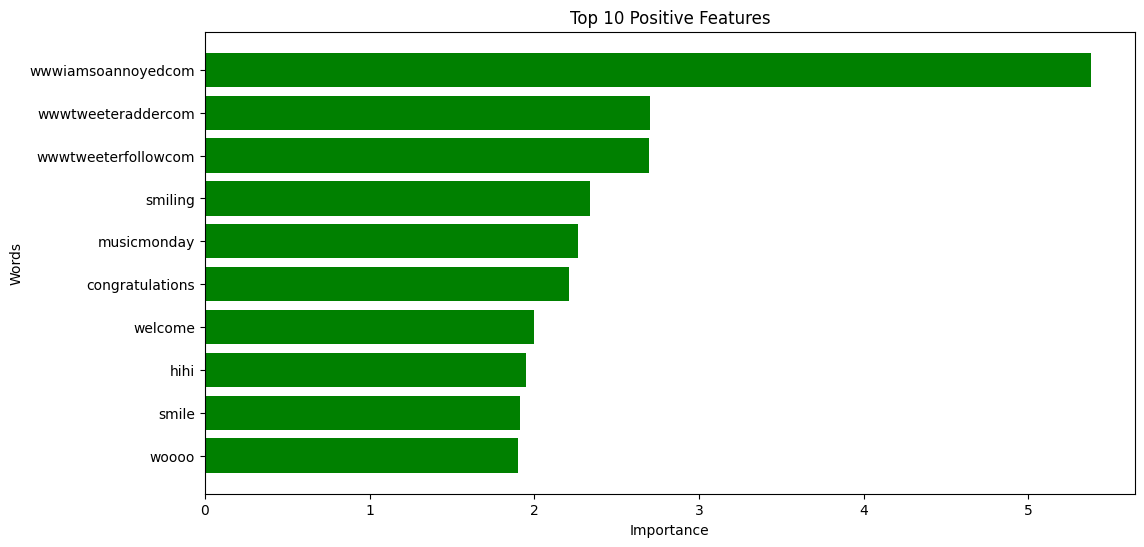

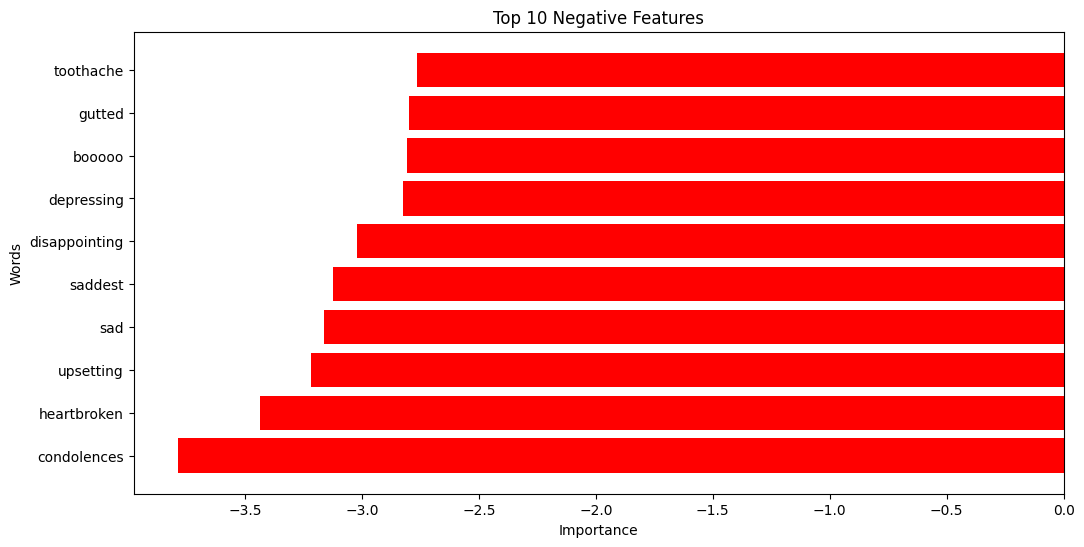

In [0]:
# ==========================
# Step 9: Feature Importance Analysis
# ==========================
import pandas as pd
import matplotlib.pyplot as plt

# Step 9.1: Extract Feature Importance (Coefficients)
# - Logistic Regression coefficients represent the importance of features in predicting sentiment
coefficients = lr_model.coefficients.toArray()
vocabulary = vectorizer_model.vocabulary

# Step 9.2: Create a DataFrame for feature importance
# - Pair coefficients with their corresponding words
feature_importance_df = pd.DataFrame({
    'Word': vocabulary,
    'Importance': coefficients
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most influential features (positive and negative)
print("Top 10 Positive Features:")
print(feature_importance_df.head(10))

print("\nTop 10 Negative Features:")
print(feature_importance_df.tail(10))

# Step 9.3: Visualize Feature Importance
# - Bar chart for top 10 positive and negative words
top_positive_features = feature_importance_df.head(10)
top_negative_features = feature_importance_df.tail(10)

# Plot positive features
plt.figure(figsize=(12, 6))
plt.barh(top_positive_features['Word'], top_positive_features['Importance'], color='green')
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Top 10 Positive Features')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Plot negative features
plt.figure(figsize=(12, 6))
plt.barh(top_negative_features['Word'], top_negative_features['Importance'], color='red')
plt.xlabel('Importance')
plt.ylabel('Words')
plt.title('Top 10 Negative Features')
plt.gca().invert_yaxis()
plt.show()


##Summarize Final Results

In [0]:
# ==========================
# Step 10: Summarize Final Results
# ==========================
import pandas as pd

# Recalculate Metrics (if not available in the workspace)
accuracy = training_summary.accuracy
precision_negative = training_summary.precisionByLabel[0]
precision_positive = training_summary.precisionByLabel[1]
recall_negative = training_summary.recallByLabel[0]
recall_positive = training_summary.recallByLabel[1]
f1_negative = training_summary.fMeasureByLabel()[0]
f1_positive = training_summary.fMeasureByLabel()[1]
weighted_f1_score = training_summary.weightedFMeasure()

# Step 10.1: Compile Evaluation Metrics into a Summary Table
evaluation_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Negative Class)', 'Precision (Positive Class)', 
               'Recall (Negative Class)', 'Recall (Positive Class)', 
               'F1 Score (Negative Class)', 'F1 Score (Positive Class)', 'Weighted F1 Score'],
    'Score': [accuracy, 
              precision_negative, precision_positive, 
              recall_negative, recall_positive, 
              f1_negative, f1_positive, weighted_f1_score]
})

# Display the summary table
print("Final Evaluation Metrics:")
display(evaluation_summary)

# Step 10.2: Generate Summary Insights (Markdown-style Text)
summary_text = f"""
### Final Results Summary:
1. **Accuracy**: {accuracy:.2f}
2. **Precision (Negative Class)**: {precision_negative:.2f}
3. **Precision (Positive Class)**: {precision_positive:.2f}
4. **Recall (Negative Class)**: {recall_negative:.2f}
5. **Recall (Positive Class)**: {recall_positive:.2f}
6. **F1 Score (Negative Class)**: {f1_negative:.2f}
7. **F1 Score (Positive Class)**: {f1_positive:.2f}
8. **Weighted F1 Score**: {weighted_f1_score:.2f}

#### Key Insights:
- The model achieves a balanced performance with high precision and recall for both classes.
- Weighted F1 Score indicates overall good performance across both negative and positive sentiment classifications.
- Feature importance analysis reveals the most influential words in determining sentiment, providing interpretability for the model.
"""

# Display the summary insights
print(summary_text)

# Step 10.3: Save Summary Insights to a Text File (Optional)
with open('/dbfs/FileStore/final_results_summary.txt', 'w') as file:
    file.write(summary_text)

# Optional: Save the metrics table as a CSV file for further reporting
evaluation_summary.to_csv('/dbfs/FileStore/final_evaluation_metrics.csv', index=False)



Final Evaluation Metrics:


Metric,Score
Accuracy,0.7761998236225491
Precision (Negative Class),0.7955948950185261
Precision (Positive Class),0.7592236422895229
Recall (Negative Class),0.7430752133198493
Recall (Positive Class),0.8092895219239213
F1 Score (Negative Class),0.7684387226713629
F1 Score (Positive Class),0.7834575475940525
Weighted F1 Score,0.7759520945279403



### Final Results Summary:
1. **Accuracy**: 0.78
2. **Precision (Negative Class)**: 0.80
3. **Precision (Positive Class)**: 0.76
4. **Recall (Negative Class)**: 0.74
5. **Recall (Positive Class)**: 0.81
6. **F1 Score (Negative Class)**: 0.77
7. **F1 Score (Positive Class)**: 0.78
8. **Weighted F1 Score**: 0.78

#### Key Insights:
- The model achieves a balanced performance with high precision and recall for both classes.
- Weighted F1 Score indicates overall good performance across both negative and positive sentiment classifications.
- Feature importance analysis reveals the most influential words in determining sentiment, providing interpretability for the model.



##Additional Visualizations

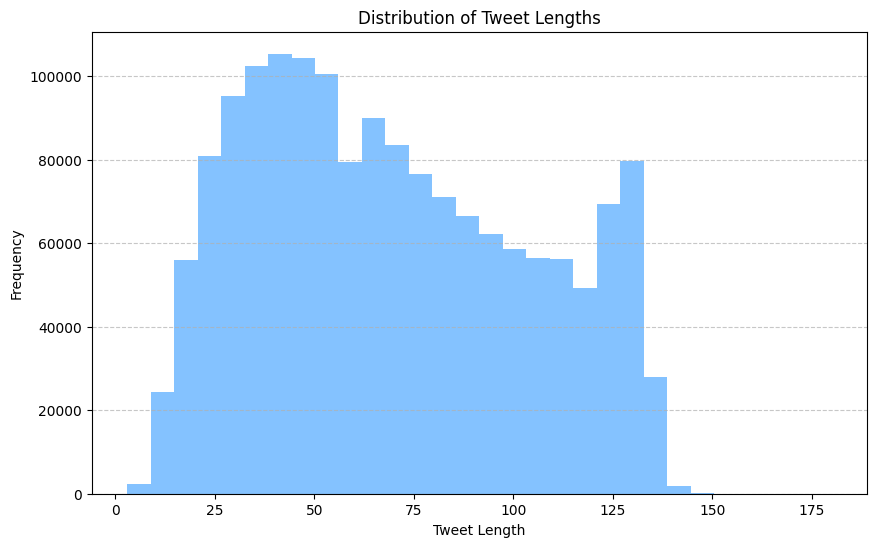

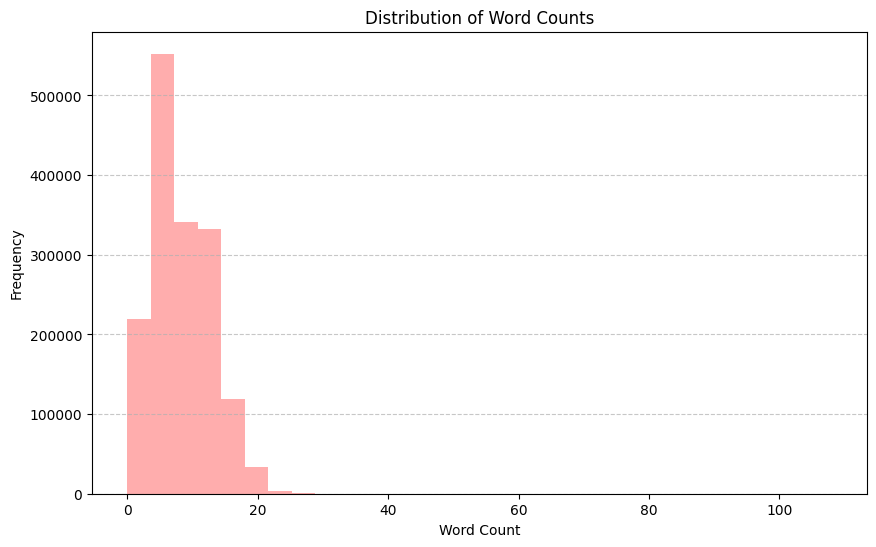

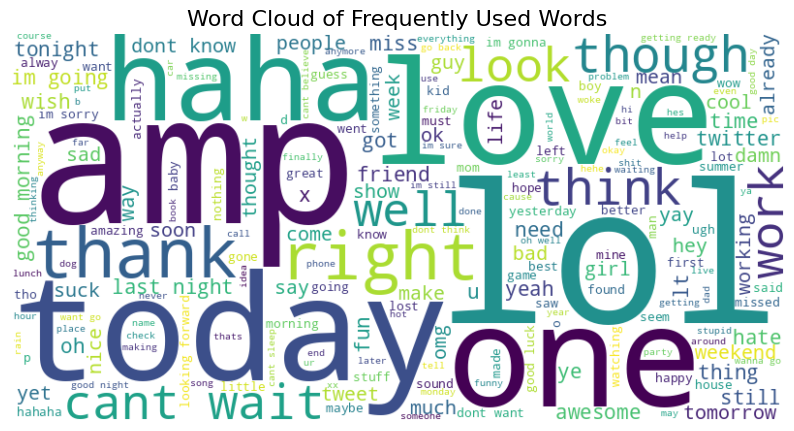

In [0]:
# ==========================
# Step 11: Additional Visualizations
# ==========================
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pyspark.sql.functions import length, size

# Visualization 1: Tweet Length Distribution
# Compute the length of each tweet
df_length = df_filtered.withColumn('tweet_length', length(col('text')))

# Collect tweet lengths for plotting
tweet_lengths = df_length.select('tweet_length').rdd.flatMap(lambda x: x).collect()

# Plot the tweet length distribution
plt.figure(figsize=(10, 6))
plt.hist(tweet_lengths, bins=30, color='#66b3ff', alpha=0.8)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 2: Word Count Distribution
# Use the `size` function to calculate the number of words in each tweet
df_word_count = df_filtered.withColumn('word_count', size(col('filtered_words')))

# Collect word counts for plotting
word_counts = df_word_count.select('word_count').rdd.flatMap(lambda x: x).collect()

# Plot the word count distribution
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, color='#ff9999', alpha=0.8)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 3: Word Cloud
# Collect all filtered words into a single list
filtered_words = df_filtered.select('filtered_words').rdd.flatMap(lambda x: x).flatMap(lambda x: x).collect()

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_words))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequently Used Words', fontsize=16)
plt.show()
